# Load Library

In [1]:
# Import our modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# price elasticity
from statsmodels.formula.api import ols

import warnings
# current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Data Preparation

In [2]:
dataset = pd.read_csv("ecommerce_data.csv")
dataset

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.390,17850.000,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.850,12680.000,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.100,12680.000,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.150,12680.000,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.150,12680.000,France


# Data Preprocessing

In [3]:
# remove rows that have missing value
dataset = dataset.dropna()

# preprocess datatype and add some new features
dataset["Sales"] = dataset["Quantity"] * dataset["UnitPrice"]
dataset["InvoiceDate"] = pd.to_datetime(dataset["InvoiceDate"])
dataset["CustomerID"] = dataset["CustomerID"].astype("int64")
dataset["InvoiceDate_date"] = dataset["InvoiceDate"].dt.date
dataset["monthyear"] = pd.to_datetime(dataset["InvoiceDate"]).dt.to_period('M').dt.to_timestamp()
dataset = dataset[dataset.Sales>0]

# filter month year period
dataset = dataset[dataset.monthyear<"2011-12"]

# filter country = United Kingdom
dataset = dataset[dataset.Country == "United Kingdom"]

dataset

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,InvoiceDate_date,monthyear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850,United Kingdom,15.300,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850,United Kingdom,20.340,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850,United Kingdom,22.000,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850,United Kingdom,20.340,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850,United Kingdom,20.340,2010-12-01,2010-12-01
...,...,...,...,...,...,...,...,...,...,...,...
516364,579885,85034C,3 ROSE MORRIS BOXED CANDLES,4,2011-11-30 17:37:00,1.250,15444,United Kingdom,5.000,2011-11-30,2011-11-01
516365,579885,21742,LARGE ROUND WICKER PLATTER,2,2011-11-30 17:37:00,5.950,15444,United Kingdom,11.900,2011-11-30,2011-11-01
516366,579885,23084,RABBIT NIGHT LIGHT,6,2011-11-30 17:37:00,2.080,15444,United Kingdom,12.480,2011-11-30,2011-11-01
516367,579885,21257,VICTORIAN SEWING BOX MEDIUM,1,2011-11-30 17:37:00,7.950,15444,United Kingdom,7.950,2011-11-30,2011-11-01


In [4]:
# explore each feature
print("Unique Product: ",dataset.StockCode.nunique())
print("Unique Customer: ",dataset.CustomerID.nunique())
print("Unique Invoice: ",dataset.InvoiceNo.nunique())
print("Total Sales: ",dataset.Sales.sum())
print("Total Quantity: ",dataset.Quantity.sum())
print("Minimum Invoice Date:  ",dataset.InvoiceDate.min())
print("Minimum Invoice Max:  ",dataset.InvoiceDate.max())

Unique Product:  3636
Unique Customer:  3886
Unique Invoice:  15940
Total Sales:  6836007.384000001
Total Quantity:  3996133
Minimum Invoice Date:   2010-12-01 08:26:00
Minimum Invoice Max:   2011-11-30 17:37:00


# Data Exploration

In [5]:
#  product performance
product = dataset.groupby(["StockCode"]).agg({'InvoiceNo':'nunique','CustomerID':'nunique',
                                              'Quantity':'sum','Sales':'sum',
                                             'UnitPrice':["min","max","mean","nunique"]}).reset_index()
product.columns = ["StockCode","unique_invoice","unique_customer","quantity","sales",
                   "min_price","mean_price","max_price","unique_price"]
product.sort_values("sales",ascending=False).head(10)

,StockCode,unique_invoice,unique_customer,quantity,sales,min_price,mean_price,max_price,unique_price
1286,22423,1372,759,9380,107913.820,4.000,24.960,12.506,5
3227,85123A,1837,815,34010,93152.860,2.400,5.790,2.893,6
1995,23166,166,124,76780,80137.850,1.040,1.250,1.228,2
3213,85099B,1412,555,41006,75517.570,1.650,4.130,2.015,8
2590,47566,1275,656,13914,62723.280,3.750,10.790,4.880,6
3054,84879,1258,630,31453,50396.530,1.450,1.690,1.682,2
1360,22502,223,167,1326,46538.300,2.000,649.500,11.468,4
2744,79321,489,197,9078,43388.890,3.820,12.460,5.412,7
984,22086,847,572,13405,36612.310,2.550,5.790,2.941,3
2100,23284,585,349,5043,33645.720,4.580,16.630,7.897,7


In [6]:
# plot quantity per unitprice
quantity_price = dataset.groupby(["StockCode","UnitPrice"]).agg({"Quantity":"sum","InvoiceDate_date":"nunique"}).reset_index()
quantity_price["quantity_per_day"] = quantity_price["Quantity"] / quantity_price["InvoiceDate_date"]
quantity_price.columns = ["StockCode","UnitPrice","Quantity","unique_date","quantity_per_day"]
quantity_price["sales_per_day"] = quantity_price["quantity_per_day"] * quantity_price["UnitPrice"]

# exclude price with date is lower than 7 days
quantity_price = quantity_price[quantity_price.unique_date>=7]

quantity_price[quantity_price.StockCode=="85099B"].sort_values("UnitPrice")

,StockCode,UnitPrice,Quantity,unique_date,quantity_per_day,sales_per_day
7186,85099B,1.650,8430,36,234.167,386.375
7187,85099B,1.740,1600,10,160.000,278.400
7189,85099B,1.790,16836,85,198.071,354.546
7190,85099B,1.950,3599,91,39.549,77.121
7192,85099B,2.080,9635,201,47.935,99.705


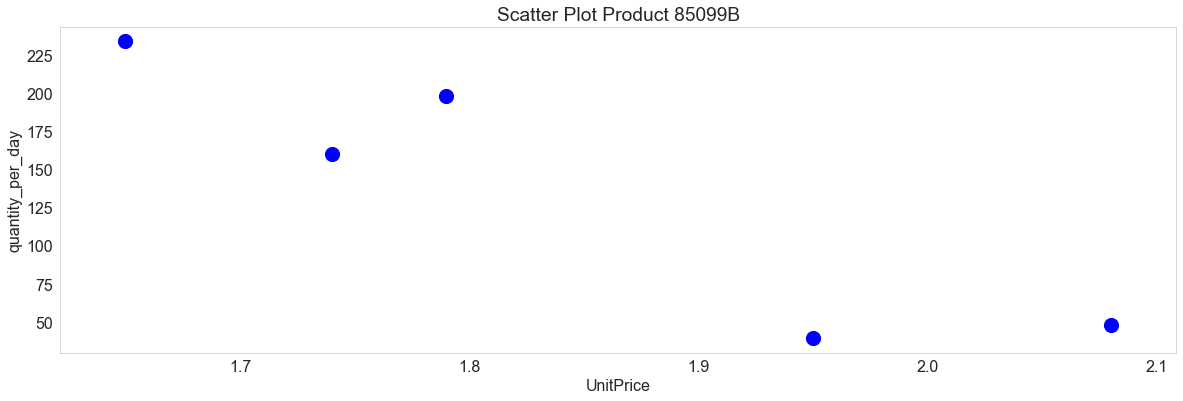

In [7]:
# plot scatter plot between unit price and quantity per day
price_dataset = quantity_price[quantity_price.StockCode=="85099B"].sort_values("UnitPrice")

# plot price
plt.rcParams["figure.figsize"] = [20, 6]
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.grid'] = False
price_dataset.plot(kind='scatter',x='UnitPrice',y='quantity_per_day',color='blue',s=200,title="Scatter Plot Product 85099B")
plt.show()

# Build a model

In [8]:
# theory: https://www.dummies.com/education/economics/econometrics/econometrics-and-the-log-log-model/
# python code: https://medium.com/@vince.shields913/econometrics-with-python-pt-4-20b7842f01df

# filter a product
data_filter = quantity_price[quantity_price.StockCode=="85099B"]

# transform variable to log value and create a model  
reg = ols("np.log(quantity_per_day) ~ np.log(UnitPrice)", data = data_filter).fit()
print(reg.summary())

                               OLS Regression Results                               
Dep. Variable:     np.log(quantity_per_day)   R-squared:                       0.829
Model:                                  OLS   Adj. R-squared:                  0.772
Method:                       Least Squares   F-statistic:                     14.58
Date:                      Sat, 25 Sep 2021   Prob (F-statistic):             0.0316
Time:                              17:01:19   Log-Likelihood:                -1.2155
No. Observations:                         5   AIC:                             6.431
Df Residuals:                             3   BIC:                             5.650
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

# Predict demand by new price

In [9]:
# generate list of numbers from 1.5 to 2.5
predict_new_price = pd.DataFrame({'UnitPrice':np.arange(1.5, 2.5, 0.05)})

# predict quantity using the model that was already generated previously 
demand_pred = np.exp(reg.predict((predict_new_price["UnitPrice"])))
demand_pred = pd.DataFrame({'quantity_per_day_predicted':demand_pred})
demand_pred = pd.concat([predict_new_price,demand_pred],axis=1)
demand_pred["sales_per_day_predicted"] = demand_pred["UnitPrice"] * demand_pred['quantity_per_day_predicted']
demand_pred

,UnitPrice,quantity_per_day_predicted,sales_per_day_predicted
0,1.500,564.591,846.886
1,1.550,431.015,668.073
2,1.600,331.874,530.998
3,1.650,257.601,425.041
4,1.700,201.468,342.496
5,1.750,158.694,277.714
6,1.800,125.844,226.520
7,1.850,100.431,185.797
8,1.900,80.633,153.203
9,1.950,65.108,126.961


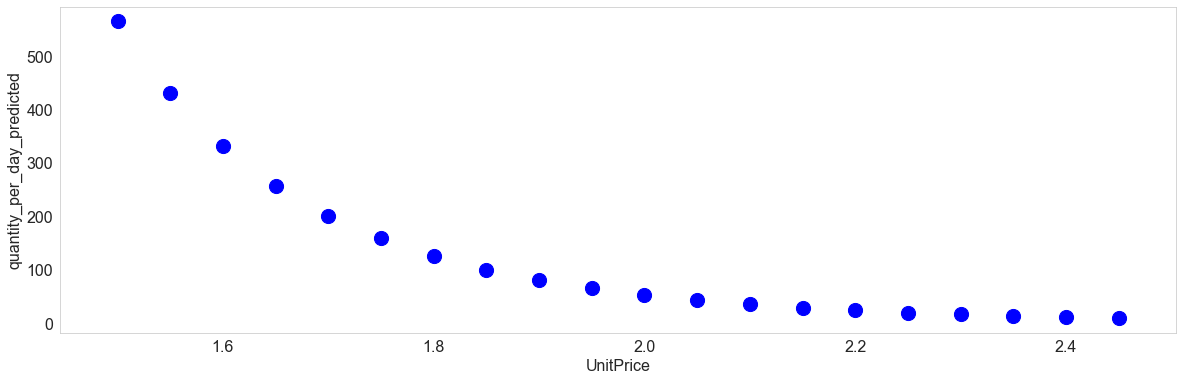

In [10]:
# plot price vs quantity
plt.rcParams["figure.figsize"] = [20, 6]
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.grid'] = False
demand_pred.plot(kind='scatter',x='UnitPrice',y='quantity_per_day_predicted',color='blue',s=200)
plt.show()

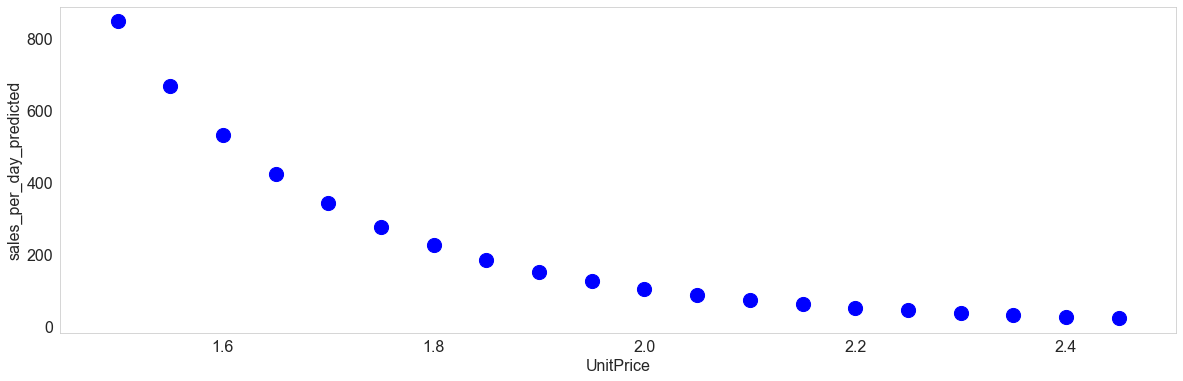

In [11]:
# plot price vs sales
plt.rcParams["figure.figsize"] = [20, 6]
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.grid'] = False
demand_pred.plot(kind='scatter',x='UnitPrice',y='sales_per_day_predicted',color='blue',s=200)
plt.show()

# Build model for > 1 products

In [12]:
# function to generate model and get price elasticity for a product
def get_price_elasticity(product):
    data_filter = quantity_price[quantity_price.StockCode==product]
    reg = ols("np.log(quantity_per_day) ~ np.log(UnitPrice)", data = data_filter).fit()
    
    if((len(data_filter) > 1) & (~pd.isna(reg.rsquared))):
        summary = pd.read_html(reg.summary().tables[1].as_html(),header=0,index_col=0)[0]['coef'].to_frame().reset_index()
        rsquared = reg.rsquared_adj
        
        if(pd.isna(reg.rsquared_adj)):
            rsquared = reg.rsquared
        summary = summary.append({'index':"rsquared_adj",'coef':rsquared},ignore_index=True).append({'index':"nobs",'coef':reg.nobs},ignore_index=True)
        summary["StockCode"] = product
        summary = summary.pivot_table('coef', "StockCode", 'index').reset_index()
        summary.columns = ["StockCode","intercept","unique_price","elasticity","rsquared_adj"]
        return summary

In [13]:
# create model for top 100 products
product_list = product.sort_values("sales",ascending=False).head(100).StockCode.unique()
result = pd.DataFrame()

for x in range(0,len(product_list)):
    result = result.append(get_price_elasticity(product_list[x]))

result = result.merge(product[["StockCode","sales","quantity","unique_customer"]],
                      on="StockCode").sort_values("sales",ascending=False)
result

,StockCode,intercept,unique_price,elasticity,rsquared_adj,sales,quantity,unique_customer
0,22423,12.503,3.000,-3.821,0.896,107913.820,9380,759
1,85123A,8.973,3.000,-4.854,0.983,93152.860,34010,815
2,23166,9.691,2.000,-31.440,1.000,80137.850,76780,124
3,85099B,9.674,5.000,-8.233,0.772,75517.570,41006,555
4,47566,12.432,4.000,-6.058,0.226,62723.280,13914,656
...,...,...,...,...,...,...,...,...
94,22385,11.639,4.000,-12.734,0.704,12281.790,6615,207
95,15056BL,23.735,2.000,-12.222,1.000,12160.310,2256,112
96,22698,12.113,2.000,-8.883,1.000,12099.400,4364,287
97,22835,13.773,3.000,-7.196,-0.273,12072.050,2597,298
